# 06.1t: Black Hole Frame Sky Map

**Goal:** View the sky using the black hole neighborhood's **own** principal component axes as the coordinate system.

In 06.1r we used the full cloud's PC axes and saw the black holes as a foreshortened stripe (edge-on view of the 3D pancake). Now we're using the black hole neighborhood's PC axes to see them from their natural perspective.

**Hypothesis:** The black holes should appear as a **blob or arc near the equator** (face-on view) instead of a vertical stripe.

**Setup:**
- Still centered at cloud centroid (gamma-prime origin)
- North/Meridian/Equinox defined by **black hole neighborhood PCs** (not cloud PCs)
- Color-coded: red (black holes), yellow (cuckoos), green (exclusion zone), blue (bulk)

**New zoom interface:**
- `CENTER_LON`, `CENTER_LAT`: where to center the view
- `ANGULAR_RADIUS`: how many degrees out from center (inscribes circle in square plot)
- Set to `None` to show full sky

This is Volume 6: Pathologies and Singularities

## Parameters

In [257]:
TENSOR_DIR = "../data/tensors"
GAMMA_FILE = "gamma_qwen3_4b_instruct_2507.safetensors"

# Which PC axes to use for coordinate system
# These will be from the BLACK HOLE NEIGHBORHOOD PCA, not the full cloud
NORTH_PC = 1
MERIDIAN_PC = 2
EQUINOX_PC = 3

# Viewing direction: rotate plot so this longitude is centered
HEADING = 0

# NEW ZOOM INTERFACE: specify center and angular radius
# Set all to None to show full sky
CENTER_LON = None  # e.g., 0
CENTER_LAT = None   # e.g., 0
ANGULAR_RADIUS = None  # e.g., 10 (degrees)

# Alternatively, use explicit bounds (overrides center/radius if set)
# LON_MIN = -179
LON_MIN = 140
# LON_MAX = 179
LON_MAX = 142
# LAT_MIN = -4
LAT_MIN = -81
# LAT_MAX = 4
LAT_MAX = -80

# Zone boundaries (distances from black hole centroid)
BLACK_HOLE_R = 1e-4
CUCKOO_R = 1e-3
EXCLUSION_R = 1e-2

# Black hole neighborhood: how far out to include for PCA?
# We want to capture black holes + cuckoos + some exclusion zone
# BH_NEIGHBORHOOD_R = 1e-2  # 1e-2 includes everything out to exclusion zone edge
BH_NEIGHBORHOOD_R = 1e-5  # 1e-5 includes black holes + cuckoos only

# Visualization
POINT_SIZE = 3
POINT_ALPHA = 1.0
FIGURE_DPI = 100

# Random seed
RANDOM_SEED = 42

## Imports

In [258]:
import torch
import numpy as np
from safetensors.torch import load_file
from pathlib import Path
import matplotlib.pyplot as plt
from collections import defaultdict

print("Imports loaded successfully.")

Imports loaded successfully.


## Step 1: Load Data and Identify Zones

In [259]:
print("Loading gamma matrix...")
gamma_path = Path(TENSOR_DIR) / GAMMA_FILE
gamma = load_file(gamma_path)['gamma']
N, d = gamma.shape
print(f"Loaded: {gamma.shape}\n")

print("Finding degenerate clusters...\n")

gamma_np = gamma.cpu().numpy()
unique_vecs, inverse_indices, counts = np.unique(
    gamma_np, 
    axis=0, 
    return_inverse=True, 
    return_counts=True
)

# Build clusters
clusters = defaultdict(list)
for token_id, unique_idx in enumerate(inverse_indices):
    clusters[unique_idx].append(token_id)

# Filter to degenerate clusters
degenerate_clusters = {idx: tokens for idx, tokens in clusters.items() if len(tokens) > 1}

# Sort by size, descending
sorted_clusters = sorted(degenerate_clusters.items(), key=lambda x: len(x[1]), reverse=True)

# Extract all black hole token IDs (top 13 clusters)
black_hole_token_ids = []
for unique_idx, token_ids in sorted_clusters[:13]:
    black_hole_token_ids.extend(token_ids)

black_hole_token_ids = sorted(black_hole_token_ids)

print(f"Identified {len(black_hole_token_ids)} black hole tokens")

# Compute black hole centroid
black_hole_embeddings = gamma[black_hole_token_ids]
bh_centroid = black_hole_embeddings.mean(dim=0)
bh_centroid_norm = torch.norm(bh_centroid)

print(f"Black hole centroid norm: {bh_centroid_norm.item():.12f}")

# Classify all tokens by zone
distances_from_bh = torch.norm(gamma - bh_centroid, dim=1)

black_hole_mask = distances_from_bh <= BLACK_HOLE_R
cuckoo_mask = (distances_from_bh > BLACK_HOLE_R) & (distances_from_bh <= CUCKOO_R)
exclusion_mask = (distances_from_bh > CUCKOO_R) & (distances_from_bh <= EXCLUSION_R)
bulk_mask = distances_from_bh > EXCLUSION_R

n_black_holes = black_hole_mask.sum().item()
n_cuckoos = cuckoo_mask.sum().item()
n_exclusion = exclusion_mask.sum().item()
n_bulk = bulk_mask.sum().item()

print(f"\nZone populations:")
print(f"  Black holes: {n_black_holes:,}")
print(f"  Cuckoos: {n_cuckoos:,}")
print(f"  Exclusion zone: {n_exclusion:,}")
print(f"  Bulk: {n_bulk:,}")

Loading gamma matrix...
Loaded: torch.Size([151936, 2560])

Finding degenerate clusters...

Identified 2100 black hole tokens
Black hole centroid norm: 0.370916873217

Zone populations:
  Black holes: 2,183
  Cuckoos: 27
  Exclusion zone: 11
  Bulk: 149,715


## Step 2: Extract Black Hole Neighborhood for PCA

In [260]:
print("\n" + "="*70)
print(f"EXTRACTING BLACK HOLE NEIGHBORHOOD (r < {BH_NEIGHBORHOOD_R:.0e})")
print("="*70)
print()

# Extract all tokens within BH_NEIGHBORHOOD_R
in_neighborhood = distances_from_bh <= BH_NEIGHBORHOOD_R
neighborhood_embeddings = gamma[in_neighborhood]

print(f"Found {len(neighborhood_embeddings):,} tokens in neighborhood")
print(f"  ({len(neighborhood_embeddings)/N*100:.4f}% of vocabulary)")


EXTRACTING BLACK HOLE NEIGHBORHOOD (r < 1e-05)

Found 0 tokens in neighborhood
  (0.0000% of vocabulary)


## Step 3: Center at Cloud Centroid and Compute PCA on Neighborhood

In [261]:
print("\n" + "="*70)
print("COMPUTING PCA ON BLACK HOLE NEIGHBORHOOD")
print("="*70)
print()

# Compute cloud centroid (from ALL tokens)
cloud_centroid = gamma.mean(dim=0)

print(f"Cloud centroid norm: {torch.norm(cloud_centroid).item():.12f}")
print(f"Black hole centroid norm: {bh_centroid_norm.item():.12f}")
print()

# Center the NEIGHBORHOOD at cloud centroid
neighborhood_centered = neighborhood_embeddings - cloud_centroid

print(f"Computing covariance matrix for neighborhood...")
Cov = (neighborhood_centered.T @ neighborhood_centered) / (len(neighborhood_embeddings) - 1)

print(f"Computing eigendecomposition...\n")
eigenvalues, eigenvectors = torch.linalg.eigh(Cov)

# Sort descending (highest variance first)
eigenvalues = eigenvalues.flip(0)
eigenvectors = eigenvectors.flip(1)

print(f"Top 10 eigenvalues (black hole neighborhood PCs):")
for i in range(10):
    variance_explained = eigenvalues[i] / eigenvalues.sum()
    print(f"  PC{i+1}: λ = {eigenvalues[i].item():.6e} ({variance_explained.item()*100:.2f}%)")

print(f"\nPCA computed successfully.")
print(f"\nThese PCs describe the structure of the black hole neighborhood.")
print(f"We'll use them as our sky map coordinate system.")


COMPUTING PCA ON BLACK HOLE NEIGHBORHOOD

Cloud centroid norm: 0.304777026176
Black hole centroid norm: 0.370916873217

Computing covariance matrix for neighborhood...
Computing eigendecomposition...

Top 10 eigenvalues (black hole neighborhood PCs):
  PC1: λ = 0.000000e+00 (nan%)
  PC2: λ = 0.000000e+00 (nan%)
  PC3: λ = 0.000000e+00 (nan%)
  PC4: λ = 0.000000e+00 (nan%)
  PC5: λ = 0.000000e+00 (nan%)
  PC6: λ = 0.000000e+00 (nan%)
  PC7: λ = 0.000000e+00 (nan%)
  PC8: λ = 0.000000e+00 (nan%)
  PC9: λ = 0.000000e+00 (nan%)
  PC10: λ = 0.000000e+00 (nan%)

PCA computed successfully.

These PCs describe the structure of the black hole neighborhood.
We'll use them as our sky map coordinate system.


## Step 4: Convert ALL Tokens to Spherical Coordinates (Using BH Neighborhood PCs)

In [262]:
print("\n" + "="*70)
print("CONVERTING TO SPHERICAL COORDINATES")
print("="*70)
print()

# Center ALL tokens at cloud centroid
gamma_prime = gamma - cloud_centroid

# Extract basis vectors (using neighborhood PCs)
north_vector = eigenvectors[:, NORTH_PC - 1]
meridian_vector = eigenvectors[:, MERIDIAN_PC - 1]
equinox_vector = eigenvectors[:, EQUINOX_PC - 1]

print(f"Coordinate system (from black hole neighborhood PCs):")
print(f"  North pole: BH-PC{NORTH_PC}")
print(f"  Prime meridian: BH-PC{MERIDIAN_PC}")
print(f"  Equinox: BH-PC{EQUINOX_PC}")
print()

# Project ALL tokens onto basis vectors
x = gamma_prime @ meridian_vector
y = gamma_prime @ equinox_vector
z = gamma_prime @ north_vector

# Compute spherical coordinates
r = torch.sqrt(x**2 + y**2 + z**2)
theta_rad = torch.asin(torch.clamp(z / r, -1, 1))
theta_deg = torch.rad2deg(theta_rad)
phi_rad = torch.atan2(y, x)
phi_deg = torch.rad2deg(phi_rad)

print(f"Latitude statistics (before CDF flattening):")
print(f"  Mean: {theta_deg.mean().item():.6f}°")
print(f"  Std: {theta_deg.std().item():.6f}°")
print(f"  Min: {theta_deg.min().item():.6f}°")
print(f"  Max: {theta_deg.max().item():.6f}°")


CONVERTING TO SPHERICAL COORDINATES

Coordinate system (from black hole neighborhood PCs):
  North pole: BH-PC1
  Prime meridian: BH-PC2
  Equinox: BH-PC3

Latitude statistics (before CDF flattening):
  Mean: -0.930443°
  Std: 39.518837°
  Min: -89.781502°
  Max: 89.615891°


## Step 5: Apply CDF Flattening to Latitude

In [263]:
print("\n" + "="*70)
print("APPLYING CDF FLATTENING")
print("="*70)
print()

# Sort latitudes to compute empirical CDF
theta_sorted, sort_indices = torch.sort(theta_deg)

# Empirical CDF values
cdf_values = torch.linspace(0, 1, N)

# Map CDF to uniform [-90°, +90°] range
theta_flat_sorted = 90.0 * (2.0 * cdf_values - 1.0)

# Unsort
theta_flat = torch.zeros_like(theta_deg)
theta_flat[sort_indices] = theta_flat_sorted

print(f"CDF flattening complete.")
print(f"\nFlattened latitude statistics:")
print(f"  Mean: {theta_flat.mean().item():.6f}°")
print(f"  Std: {theta_flat.std().item():.6f}°")
print(f"  Min: {theta_flat.min().item():.6f}°")
print(f"  Max: {theta_flat.max().item():.6f}°")


APPLYING CDF FLATTENING

CDF flattening complete.

Flattened latitude statistics:
  Mean: -0.000000°
  Std: 51.962036°
  Min: -90.000000°
  Max: 90.000000°


## Step 6: Apply Heading Rotation

In [264]:
# Shift longitude by HEADING degrees
phi_rotated = phi_deg - HEADING

# Wrap to [-180°, +180°] range
phi_rotated = torch.where(phi_rotated > 180, phi_rotated - 360, phi_rotated)
phi_rotated = torch.where(phi_rotated < -180, phi_rotated + 360, phi_rotated)

print(f"Applied heading rotation: {HEADING}°")

Applied heading rotation: 0°


## Step 7: Determine Plot Limits (New Zoom Interface)

In [265]:
print("\n" + "="*70)
print("DETERMINING PLOT LIMITS")
print("="*70)
print()

# Priority: explicit bounds > center/radius > full sky
if LON_MIN is not None and LON_MAX is not None:
    # Use explicit bounds
    lon_min = LON_MIN
    lon_max = LON_MAX
    lat_min = LAT_MIN if LAT_MIN is not None else -90
    lat_max = LAT_MAX if LAT_MAX is not None else 90
    zoom_mode = "explicit bounds"
elif CENTER_LON is not None and CENTER_LAT is not None and ANGULAR_RADIUS is not None:
    # Use center + radius (inscribe circle in square)
    lon_min = CENTER_LON - ANGULAR_RADIUS
    lon_max = CENTER_LON + ANGULAR_RADIUS
    lat_min = CENTER_LAT - ANGULAR_RADIUS
    lat_max = CENTER_LAT + ANGULAR_RADIUS
    zoom_mode = f"centered at ({CENTER_LON}°, {CENTER_LAT}°), radius {ANGULAR_RADIUS}°"
else:
    # Full sky
    lon_min = -180
    lon_max = 180
    lat_min = -90
    lat_max = 90
    zoom_mode = "full sky"

print(f"Zoom mode: {zoom_mode}")
print(f"  Longitude: [{lon_min}°, {lon_max}°]")
print(f"  Latitude: [{lat_min}°, {lat_max}°]")


DETERMINING PLOT LIMITS

Zoom mode: explicit bounds
  Longitude: [140°, 142°]
  Latitude: [-81°, -80°]


## Step 8: Where Are the Black Holes?

In [266]:
print("\n" + "="*70)
print("BLACK HOLE LOCATIONS IN THIS COORDINATE SYSTEM")
print("="*70)
print()

# Extract black hole coordinates
bh_lons = phi_rotated[black_hole_mask].cpu().numpy()
bh_lats = theta_flat[black_hole_mask].cpu().numpy()

print(f"Black hole longitude range: [{bh_lons.min():.2f}°, {bh_lons.max():.2f}°]")
print(f"Black hole latitude range: [{bh_lats.min():.2f}°, {bh_lats.max():.2f}°]")
print(f"Longitude span: {bh_lons.max() - bh_lons.min():.2f}°")
print(f"Latitude span: {bh_lats.max() - bh_lats.min():.2f}°")
print()
print(f"Mean position: ({bh_lons.mean():.2f}°, {bh_lats.mean():.2f}°)")
print()
print("If they form a blob, lon/lat spans will be comparable.")
print("If they form a stripe, one span will be much larger than the other.")


BLACK HOLE LOCATIONS IN THIS COORDINATE SYSTEM

Black hole longitude range: [140.90°, 140.90°]
Black hole latitude range: [-81.10°, -78.50°]
Longitude span: 0.00°
Latitude span: 2.60°

Mean position: (140.90°, -79.80°)

If they form a blob, lon/lat spans will be comparable.
If they form a stripe, one span will be much larger than the other.


## Step 9: Create Zone-Colored Sky Map


CREATING SKY MAP



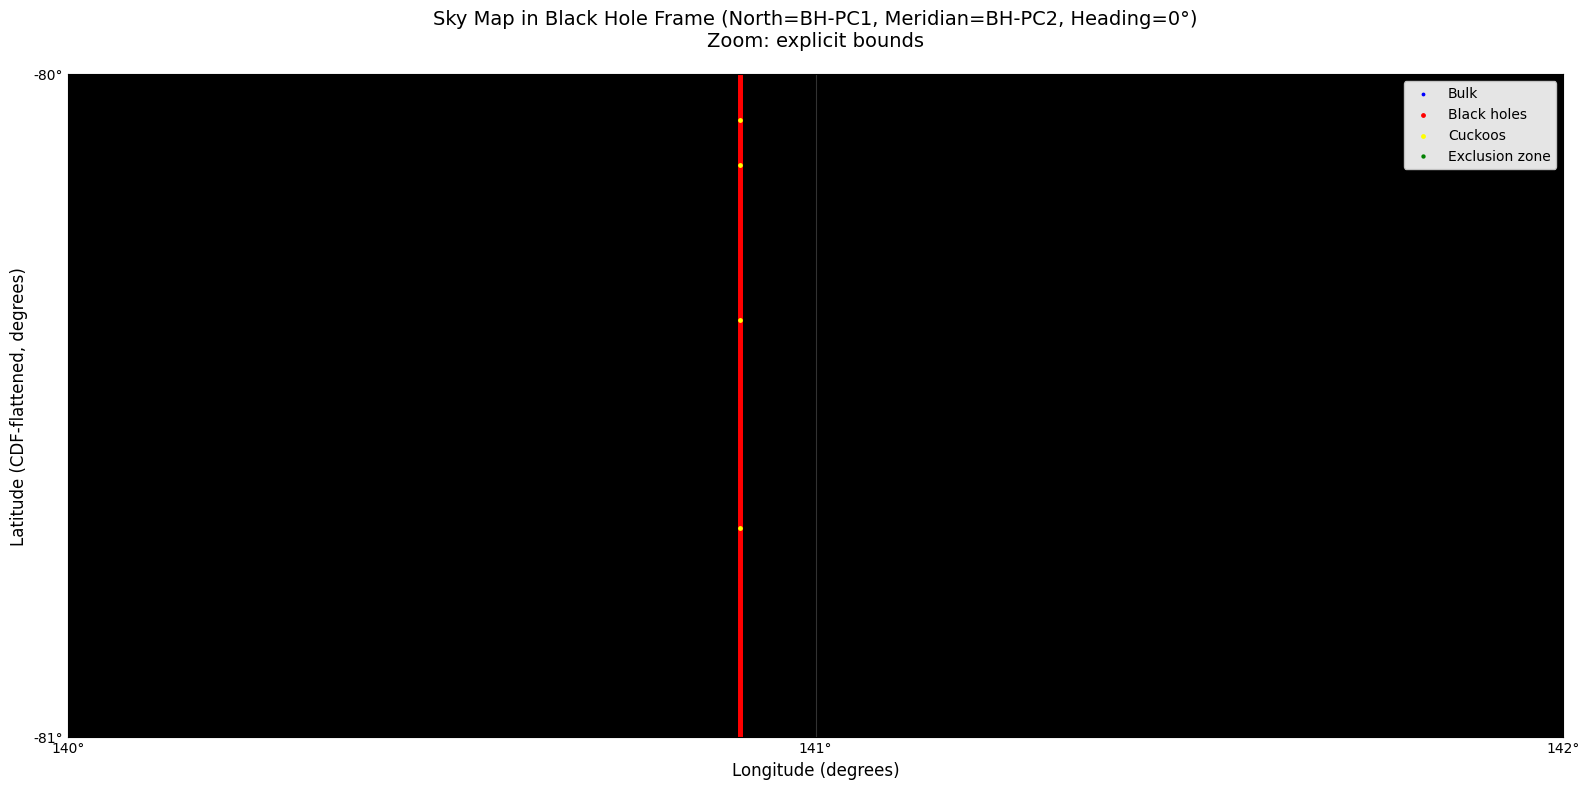


Sky map complete.
  Red: 2,183 black holes
  Yellow: 27 cuckoos
  Green: 11 exclusion zone tokens
  Blue: 149,715 bulk tokens


In [267]:
print("\n" + "="*70)
print("CREATING SKY MAP")
print("="*70)
print()

# Convert to numpy
phi_np = phi_rotated.cpu().numpy()
theta_flat_np = theta_flat.cpu().numpy()
black_hole_np = black_hole_mask.cpu().numpy()
cuckoo_np = cuckoo_mask.cpu().numpy()
exclusion_np = exclusion_mask.cpu().numpy()
bulk_np = bulk_mask.cpu().numpy()

# Create figure
fig, ax = plt.subplots(figsize=(16, 8), dpi=FIGURE_DPI)
ax.set_facecolor('black')

# Plot in order: bulk first (background), then black holes, then cuckoos, then exclusion (foreground)
ax.scatter(phi_np[bulk_np], theta_flat_np[bulk_np],
           s=POINT_SIZE, alpha=POINT_ALPHA, c='blue', label='Bulk', rasterized=True)

ax.scatter(phi_np[black_hole_np], theta_flat_np[black_hole_np],
           s=POINT_SIZE*2, alpha=POINT_ALPHA, c='red', label='Black holes', rasterized=True)

ax.scatter(phi_np[cuckoo_np], theta_flat_np[cuckoo_np],
           s=POINT_SIZE*2, alpha=POINT_ALPHA, c='yellow', label='Cuckoos', rasterized=True)

ax.scatter(phi_np[exclusion_np], theta_flat_np[exclusion_np],
           s=POINT_SIZE*1.5, alpha=POINT_ALPHA, c='green', label='Exclusion zone', rasterized=True)

# Set tick spacing
lon_range = lon_max - lon_min
lat_range = lat_max - lat_min

if lon_range <= 20:
    lon_tick_spacing = 1
elif lon_range <= 60:
    lon_tick_spacing = 5
else:
    lon_tick_spacing = 15

if lat_range <= 20:
    lat_tick_spacing = 1
elif lat_range <= 60:
    lat_tick_spacing = 5
else:
    lat_tick_spacing = 10

lon_ticks = np.arange(
    np.ceil(lon_min / lon_tick_spacing) * lon_tick_spacing,
    lon_max + lon_tick_spacing,
    lon_tick_spacing
)
lat_ticks = np.arange(
    np.ceil(lat_min / lat_tick_spacing) * lat_tick_spacing,
    lat_max + lat_tick_spacing,
    lat_tick_spacing
)

ax.set_xticks(lon_ticks)
ax.set_yticks(lat_ticks)
ax.set_xticklabels([f'{int(lon)}°' for lon in lon_ticks])
ax.set_yticklabels([f'{int(lat)}°' for lat in lat_ticks])
ax.tick_params(axis='both', which='both', length=0, colors='black')

ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)
ax.grid(True, alpha=0.2, color='white', which='major')

ax.set_xlabel('Longitude (degrees)', color='black', fontsize=12)
ax.set_ylabel('Latitude (CDF-flattened, degrees)', color='black', fontsize=12)

# Title
title = f'Sky Map in Black Hole Frame (North=BH-PC{NORTH_PC}, Meridian=BH-PC{MERIDIAN_PC}, Heading={HEADING}°)\n'
if zoom_mode != "full sky":
    title += f'Zoom: {zoom_mode}'

ax.set_title(title, color='black', pad=20, fontsize=14)

for spine in ax.spines.values():
    spine.set_edgecolor('black')

# Legend with opaque markers
legend = ax.legend(loc='upper right', framealpha=0.9, fontsize=10)
for handle in legend.legend_handles:
    handle.set_alpha(1.0)

plt.tight_layout()
plt.show()

print(f"\nSky map complete.")
print(f"  Red: {n_black_holes:,} black holes")
print(f"  Yellow: {n_cuckoos:,} cuckoos")
print(f"  Green: {n_exclusion:,} exclusion zone tokens")
print(f"  Blue: {n_bulk:,} bulk tokens")

## Summary

We viewed the sky using the black hole neighborhood's own PC axes as the coordinate system.

**Key question:** Do the black holes appear as a blob (face-on view) or a stripe (edge-on view)?

**Method:**
1. Extracted black hole neighborhood (r < 1e-2 from BH centroid)
2. Computed PCA on neighborhood (centered at cloud centroid)
3. Used neighborhood PCs as coordinate axes
4. Converted all tokens to spherical coords in this frame
5. Plotted sky map colored by zone

**Interpretation:**
- If lon/lat spans are comparable → blob (face-on)
- If one span >> other → stripe (edge-on from different angle)
- Cuckoos should appear scattered regardless (they're in orthogonal dimensions)

This reveals the 3D pancake from the singularity's own perspective!